In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from icecream import ic
from itertools import product
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Point
from skimage.morphology import dilation, square
from utils import RCM_DICT, MODEL_DICT, cities
import cartopy.crs as ccrs
import cf_xarray as cfxr
import dask
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import xarray as xr

In [3]:
from urban_areas import (
    load_fixed_variables,
    fix_sftuf,
    Urban_vicinity,
    load_variable,
    kelvin2degC,
    load_ucdb_city,
)
from GHCNd_stations import (
    load_ghcnd_stations,
    get_ghcnd_df,
    get_valid_timeseries,
    available_vars,
    get_season
)
from plot_functions import (
    plot_climatology,
    plot_time_series
)

## Define urban areas and vicinity

### Define input parameters

In [4]:
# This cell is tagged 'Parameters'
city = 'Paris'
observations = True
domain = 'EUR-22'
model = 'REMO' # REMO/RegCM
scenario = 'evaluation'
variable = 'tasmin'
root_esgf = '/lustre/gmeteo/DATA/ESGF/REPLICA/DATA/cordex/output/'
root_nextcloud = '/lustre/gmeteo/WORK/DATA/CORDEX-FPS-URB-RCC/nextcloud/CORDEX-CORE-WG/'
base_output_dir = 'results'

lon_city = 2.35
lat_city = 48.85

urban_th = 0.1
urban_sur_th = 0.1
orog_diff = 100
sftlf_th = 70
scale = 2
lon_lim = 1
lat_lim = 1

Create a directory to save the results for this particular city and model

In [5]:
model_str = RCM_DICT[domain][model]
abbr_city = cities[city]['city']
output_dir = f"{base_output_dir}/{abbr_city}-{domain}_{model_str}"
os.makedirs(output_dir, exist_ok = True)

In [6]:
domain_resolution = int(domain.split('-')[1])
base_filename = f'{abbr_city}-{domain}_ECMWF-ERAINT_{scenario}_r1i1p1_{model_str}'

##### Load fix variables

In [7]:
ds_sftuf, ds_orog, ds_sftlf = load_fixed_variables(domain, model, root_esgf, root_nextcloud)
# fix some issues for sftuf
ds_sftuf = fix_sftuf(domain, model, ds_sftuf, ds_orog, ds_sftlf)

##### Add parameters to the function

In [8]:
URBAN = Urban_vicinity(
    urban_th, 
    urban_sur_th, 
    orog_diff, 
    sftlf_th,
    scale,
    lon_city,
    lat_city,
    lon_lim,
    lat_lim,
    model_str,
    domain)

##### Crop area around de city

In [9]:
ds_sftuf = URBAN.crop_area_city(ds_sftuf, domain_resolution)
ds_orog = URBAN.crop_area_city(ds_orog, domain_resolution)
ds_sftlf = URBAN.crop_area_city(ds_sftlf, domain_resolution)

##### Define masks

In [10]:
# define masks
sftuf_mask, sftuf_sur_mask, orog_mask, sftlf_mask = URBAN.define_masks(
    ds_sftuf, 
    ds_orog, 
    ds_sftlf
)

##### Plot masks

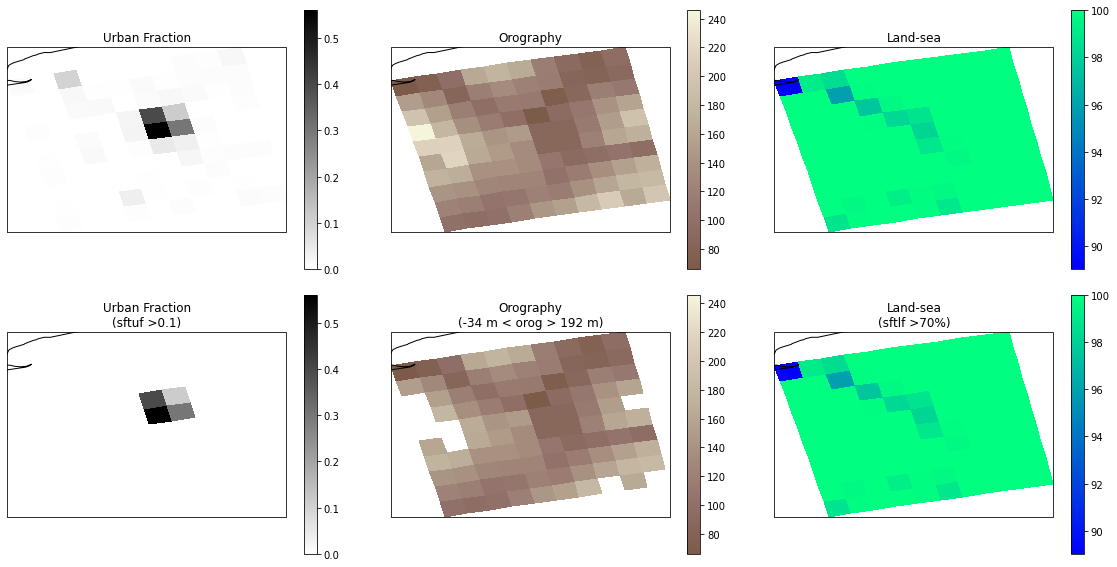

In [11]:
# plot mask
fig = URBAN.plot_fixed_variables(ds_sftuf, ds_orog, ds_sftlf,
                                 sftuf_mask, orog_mask, sftlf_mask)

#### Define rural vicinity areas

In [12]:
urmask = URBAN.select_urban_vicinity(
    sftuf_mask, 
    orog_mask,
    sftlf_mask,
    sftuf_sur_mask
)

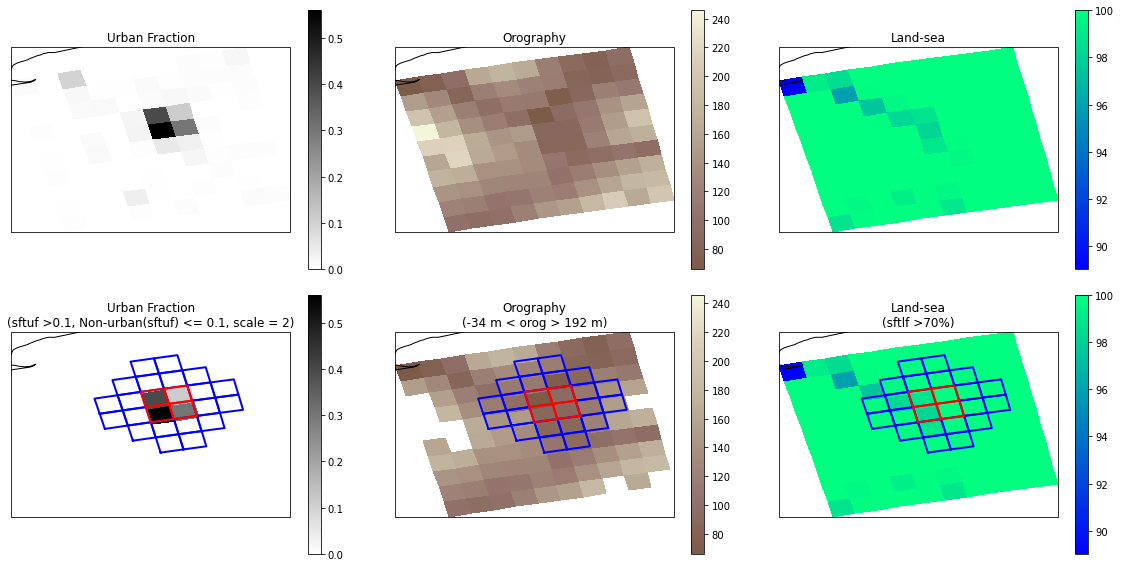

In [13]:
# plot mask and urban vs vicinity
fig = URBAN.plot_fixed_variables(ds_sftuf, ds_orog, ds_sftlf,
                                 sftuf_mask, orog_mask, sftlf_mask,
                                 urmask)
fig.savefig(f"{output_dir}/urmask_{base_filename}_fx.pdf", bbox_inches='tight')

In [14]:
# save netcdf
urmask.to_netcdf(f"{output_dir}/urmask_{base_filename}_fx.nc")

## Calculate urban heat island effect

Remember that we selected above the following parameters:

In [15]:
ic(variable)
ic(city)
ic(observations)

ic| variable: 'tasmin'
ic| city: 'Paris'
ic| observations: True


True

#### Load city shapefile

In [16]:
ucdb_city = load_ucdb_city(root_nextcloud, city)

#### Load variable from ESGF DRS

In [17]:
cachefile = f"{output_dir}/{variable}_{base_filename}_day.nc"
if os.path.exists(cachefile):
  print('Reading from cache file.')
  ds_RCM = xr.open_dataset(cachefile)
else:
  ds_RCM = load_variable(root_esgf, root_nextcloud, variable, domain, model, scenario)
  ds_RCM = kelvin2degC(ds_RCM, variable)
  ds_RCM = URBAN.crop_area_city(ds_RCM, domain_resolution)
  ds_RCM.to_netcdf(cachefile)


/vols/abedul/meteo/chus/usr/mambaforge/envs/pyclimenv/lib/python3.10/site-packages/xarray/conventions.py:445: UserWarning: Variable 'time' has datetime type and a bounds variable but time.encoding does not have units specified. The units encodings for 'time' and 'time_bnds' will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for 'time' before writing to a file.
  warnings.warn(


#### Load observations

In [18]:
GHCNd = load_ghcnd_stations(lon_city, lat_city, radious = 0.5)

/lustre/gmeteo/WORK/ASNA/projects/fpsurbrcc/03_cordexcore_wg/CORDEX-CORE-WG/uhi/GHCNd_stations.py:28: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  rval = ghcnd_stations.assign(dist = ghcnd_stations.distance(Point(lon, lat)))


#### Select coincident period between Model and Observations

In [19]:
valid_obs, time_series_obs, ds_RCM_period = get_valid_timeseries(
    city, GHCNd, ds_RCM, variable, idate = '1980-01-01', fdate = '2016-12-31')

Problem downloading FR000007150
Paris -- ORLY, FR - TMIN has 100.0% valid records in 1980-01-01 to 2016-12-31


In [20]:
ds_RCM_period_season, time_series_obs_season = get_season(
    ds_RCM_period, time_series_obs, season = 'all')

#### Compute climatology (rural annomaly)

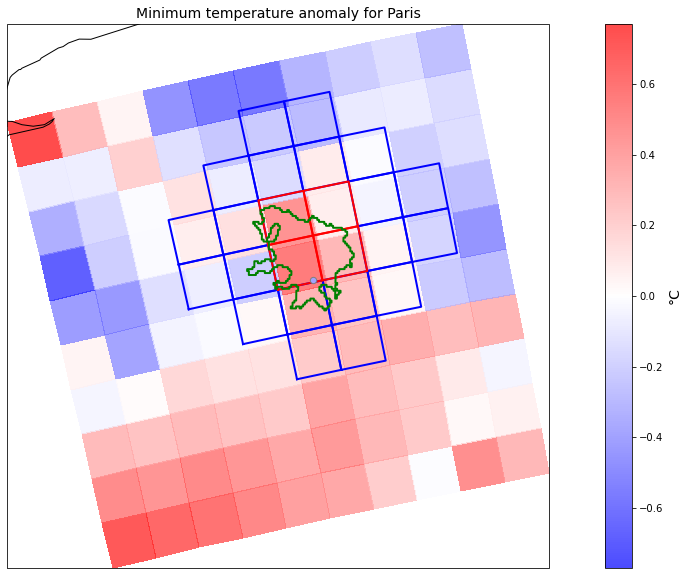

In [21]:
fig = plot_climatology(ds_RCM_period_season, ucdb_city, urmask, variable, 
                       URBAN, valid_obs, time_series_obs_season, city)
fig.savefig(f"{output_dir}/map_{variable}_{base_filename}_day.pdf", bbox_inches='tight')

KeyboardInterrupt: 

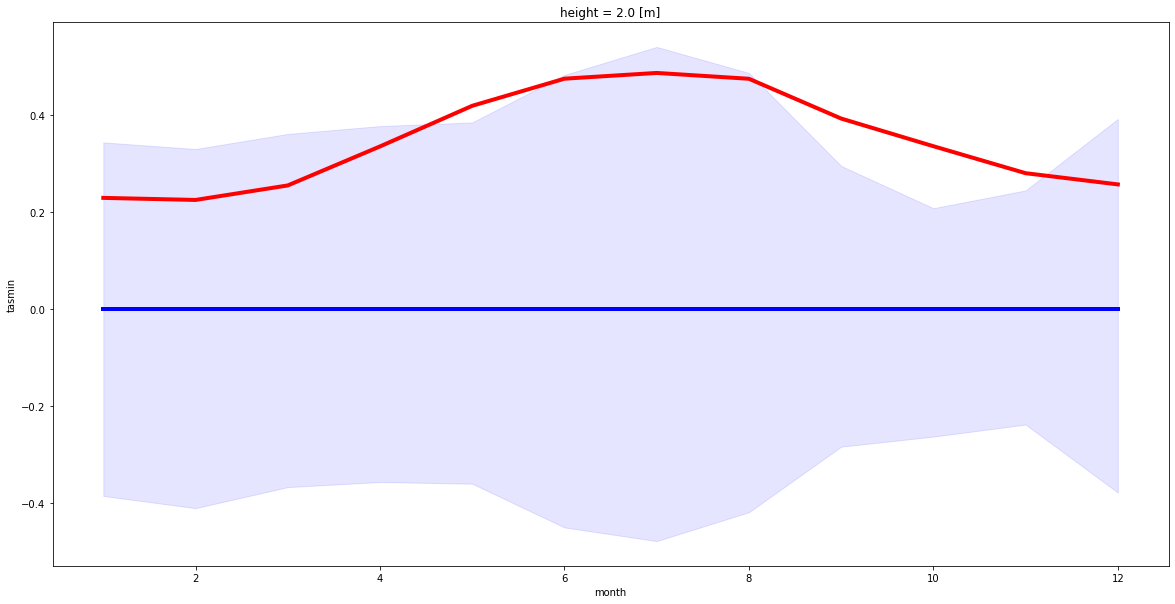

In [22]:
cachefile = f"{output_dir}/{variable}_{base_filename}_acycle-ur.nc"
fig = plot_time_series(ds_RCM, variable, urmask, data_squares = True, city = city, cache = cachefile)
fig.savefig(cachefile.replace('.nc', '.pdf'), bbox_inches='tight')

In [ ]:
cachefile = f"{output_dir}/{variable}_{base_filename}_acycle-ur-obs.nc"
fig = plot_time_series(ds_RCM, variable, urmask, time_series_obs, 
                       valid_obs, data_squares = True, cache = cachefile)
fig.savefig(cachefile.replace('.nc', '.pdf'), bbox_inches='tight')